__Purpose:__ Test the performance of already trained decoders to see if they continue to achieve the best performance, and to see if personalization is necessary/possible.  Ideally, this NB should show that the outputs of previous training rounds will maintain their high performance.  I am ambivalent about whether or not we would expect any further improvement over training.

In [1]:
import pandas as pd
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import copy

from experiment_params import *
from cost_funcs import *
from fl_sim_classes import *
import time
import pickle
from sklearn.decomposition import PCA

In [2]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

# For exclusion when plotting later on
bad_nodes = [1,3,13]

# Verify Federated Set Up Runs

In [3]:
with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)
    
with open(path+all_decs_init_filename, 'rb') as fp:
    init_decoders = pickle.load(fp)
cond0_init_decs = [dec[0, :, :] for dec in init_decoders]

In [4]:
D_0 = np.random.rand(2,64)
D_0_7 = np.random.rand(2,7)

# No-FL Case

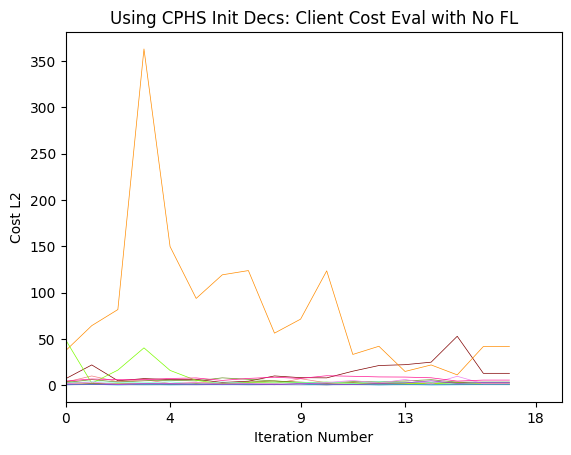

In [5]:
user_c0_no_fl_w_cphs_init = [Client(i, cond0_init_decs[i], 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model_no_fl_w_cphs_init = Server(-1, D_0, 'NoFL', user_c0_no_fl_w_cphs_init, PCA_comps=64)

num_updates_left = 18
for i in range(num_updates_left):
    global_model_no_fl_w_cphs_init.execute_FL_loop()
    
condensed_external_plotting(user_c0_no_fl_w_cphs_init, 'local', global_error=False, dim_reduc_factor=1, show_update_change=False, custom_title='Using CPHS Init Decs: Client Cost Eval with No FL')

## Using Final Client Decs as Inits

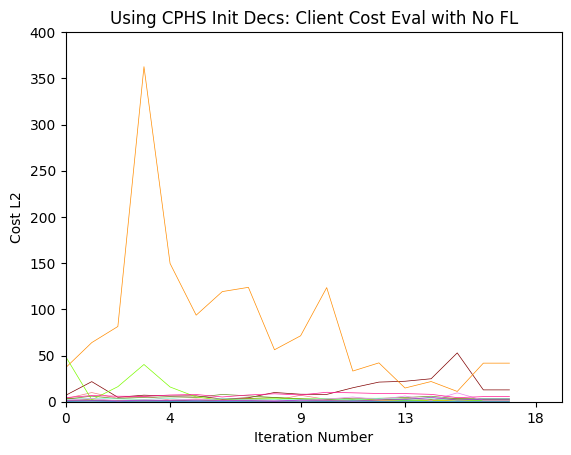

In [6]:
user_c0_no_fl_wclient_init = [Client(i, user_c0_no_fl_w_cphs_init[i].w, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model_no_fl_wclient_init = Server(-1, D_0, 'NoFL', user_c0_no_fl_wclient_init, PCA_comps=64)

num_updates_left = 18
for i in range(num_updates_left):
    global_model_no_fl_wclient_init.execute_FL_loop()
    
condensed_external_plotting(user_c0_no_fl_wclient_init, 'local', global_error=False, dim_reduc_factor=1, show_update_change=False, ylim_max=400, custom_title='Using CPHS Init Decs: Client Cost Eval with No FL')

## Using Final Global Model as Init for All

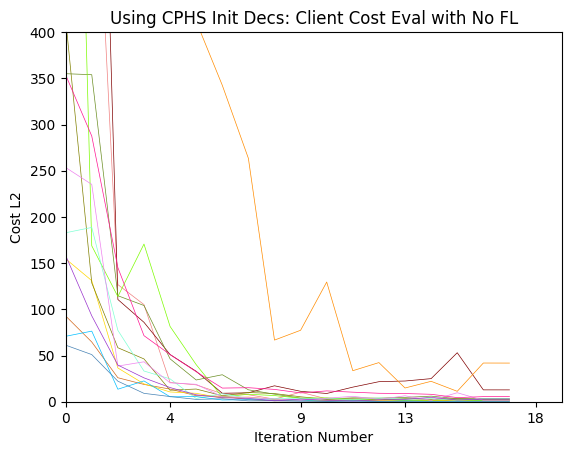

In [7]:
user_c0_no_fl_wglobal_init = [Client(i, global_model_no_fl_w_cphs_init.w, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model_no_fl_wglobal_init = Server(-1, D_0, 'NoFL', user_c0_no_fl_wglobal_init, PCA_comps=64)

num_updates_left = 18
for i in range(num_updates_left):
    global_model_no_fl_wglobal_init.execute_FL_loop()
    
condensed_external_plotting(user_c0_no_fl_wglobal_init, 'local', global_error=False, ylim_max=400, dim_reduc_factor=1, show_update_change=False, custom_title='Using CPHS Init Decs: Client Cost Eval with No FL')

## Using Final Global Model as Init for All
> Global model also set to prev final global

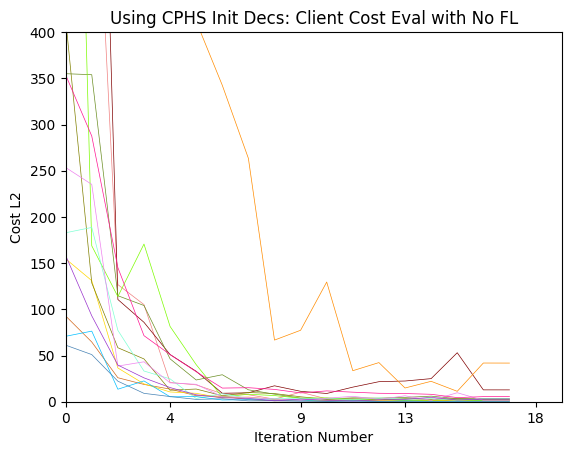

In [8]:
user_c0_no_fl_wglobalx2_init = [Client(i, global_model_no_fl_w_cphs_init.w, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model_no_fl_wglobalx2_init = Server(-1, global_model_no_fl_w_cphs_init.w, 'NoFL', user_c0_no_fl_wglobalx2_init, PCA_comps=64)

num_updates_left = 18
for i in range(num_updates_left):
    global_model_no_fl_wglobalx2_init.execute_FL_loop()
    
condensed_external_plotting(user_c0_no_fl_wglobalx2_init, 'local', global_error=False, ylim_max=400, dim_reduc_factor=1, show_update_change=False, custom_title='Using CPHS Init Decs: Client Cost Eval with No FL')

# Federated Learning
## 1 Scipy Step, 2000 Iterations
> Note that the thicker, lighter lines are the global model accuracies, whereas the thin lines are the local accuracies.

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 0, 25)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 0, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 0, 75)

Client 1: New update after lrt passed: (new update, current global round, current local round): (14, 0, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (15, 0, 125)

Client 1: New update after lrt passed: (new update, current global round, current local round): (16, 0, 150)



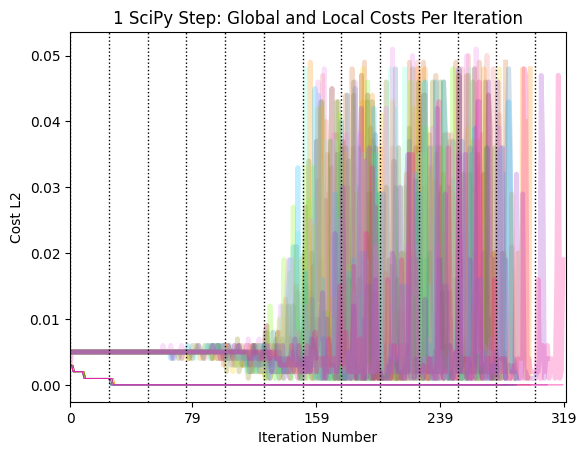

In [9]:
user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 2000
for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')

## Using Final Client Decs as Inits

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 0, 25)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 0, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 0, 75)

Client 1: New update after lrt passed: (new update, current global round, current local round): (14, 0, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (15, 0, 125)

Client 1: New update after lrt passed: (new update, current global round, current local round): (16, 0, 150)



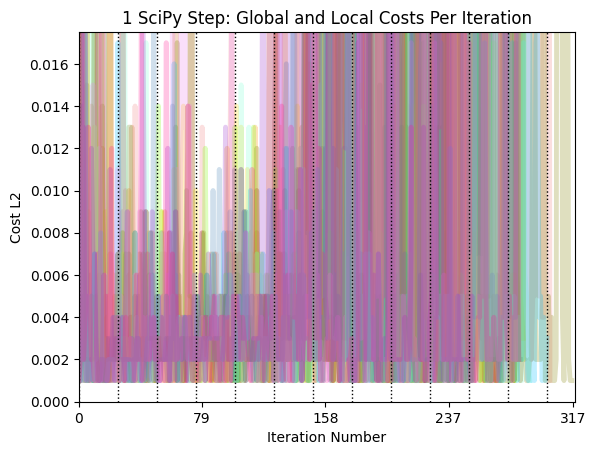

In [10]:
user_c0_1ScipyStep_wclient_init = [Client(i, user_c0_1ScipyStep[i].w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep_wclient_init = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep_wclient_init)

big_loop_iters = 2000
for i in range(big_loop_iters):
    global_model_1scipystep_wclient_init.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep_wclient_init, 'local', ylim_max=0.0175, custom_title='1 SciPy Step: Global and Local Costs Per Iteration')

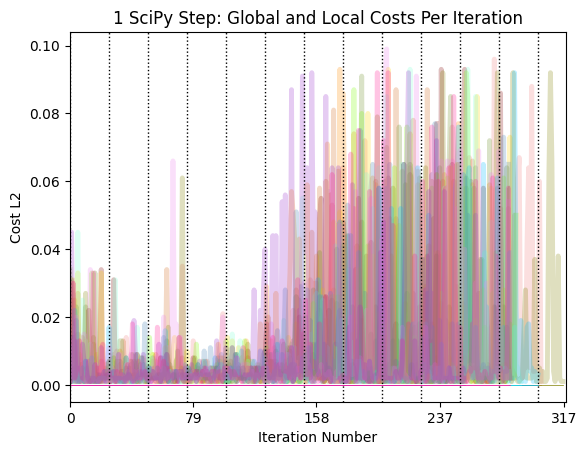

In [11]:
condensed_external_plotting(user_c0_1ScipyStep_wclient_init, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')

## Using Final Global Model as Init for All

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 0, 25)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 0, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 0, 75)

Client 1: New update after lrt passed: (new update, current global round, current local round): (14, 0, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (15, 0, 125)

Client 1: New update after lrt passed: (new update, current global round, current local round): (16, 0, 150)



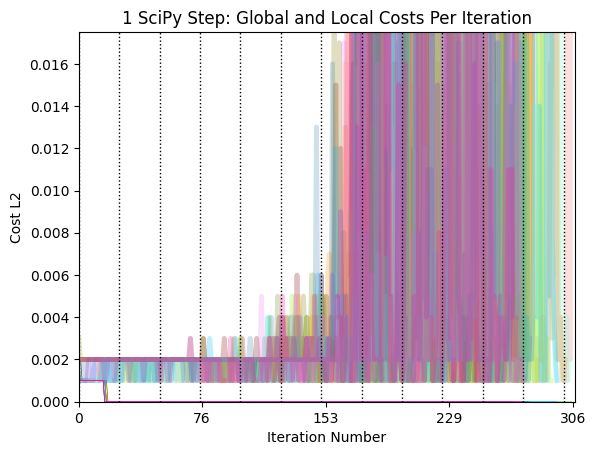

In [12]:
user_c0_1ScipyStep_wglobal_init = [Client(i, global_model_1scipystep.w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep_wglobal_init = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep_wglobal_init)

big_loop_iters = 2000
for i in range(big_loop_iters):
    global_model_1scipystep_wglobal_init.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep_wglobal_init, 'local', ylim_max=0.0175, custom_title='1 SciPy Step: Global and Local Costs Per Iteration')

## Using Final Global Model as Init for All
> Global model also set to prev final global

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 0, 25)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 0, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 0, 75)

Client 1: New update after lrt passed: (new update, current global round, current local round): (14, 0, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (15, 0, 125)

Client 1: New update after lrt passed: (new update, current global round, current local round): (16, 0, 150)



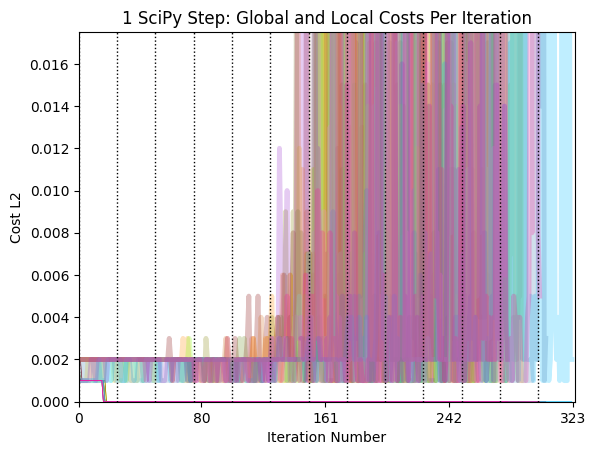

In [13]:
user_c0_1ScipyStep_wglobalx2_init = [Client(i, global_model_1scipystep.w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep_wglobalx2_init = Server(1, global_model_1scipystep.w, 'FedAvg', user_c0_1ScipyStep_wglobalx2_init)

big_loop_iters = 2000
for i in range(big_loop_iters):
    global_model_1scipystep_wglobalx2_init.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep_wglobalx2_init, 'local', ylim_max=0.0175, custom_title='1 SciPy Step: Global and Local Costs Per Iteration')

## 10 Steps

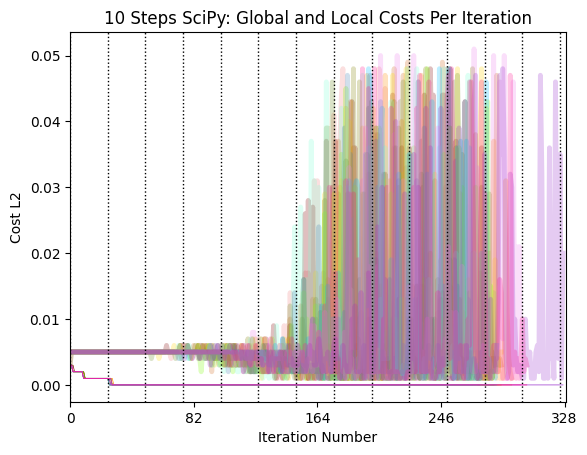

In [14]:
user_c0_10scipy = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', num_steps=10, delay_scaling=0) for i in range(14)]
global_model_10scipy = Server(2, D_0_7, 'FedAvg', user_c0_10scipy)

for i in range(big_loop_iters):
    global_model_10scipy.execute_FL_loop()
    
condensed_external_plotting(user_c0_10scipy, 'local', custom_title='10 Steps SciPy: Global and Local Costs Per Iteration')

## Using Final Client Decs as Inits

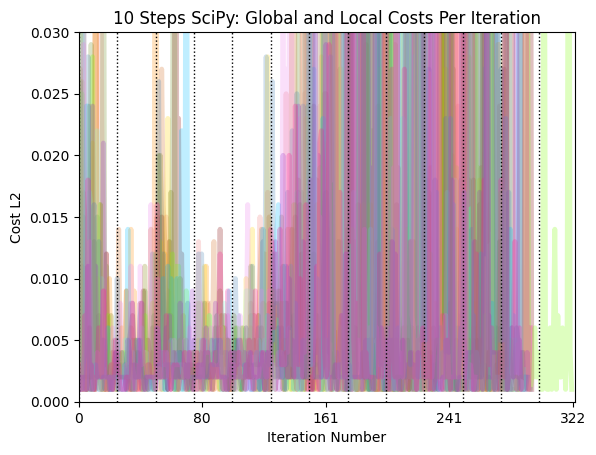

In [15]:
user_c0_10scipy_wclient_init = [Client(i, user_c0_10scipy[i].w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', num_steps=10, delay_scaling=0) for i in range(14)]
global_model_10scipy_wclient_init = Server(2, D_0_7, 'FedAvg', user_c0_10scipy_wclient_init)

for i in range(big_loop_iters):
    global_model_10scipy_wclient_init.execute_FL_loop()
    
condensed_external_plotting(user_c0_10scipy_wclient_init, 'local', ylim_max=0.03, custom_title='10 Steps SciPy: Global and Local Costs Per Iteration')

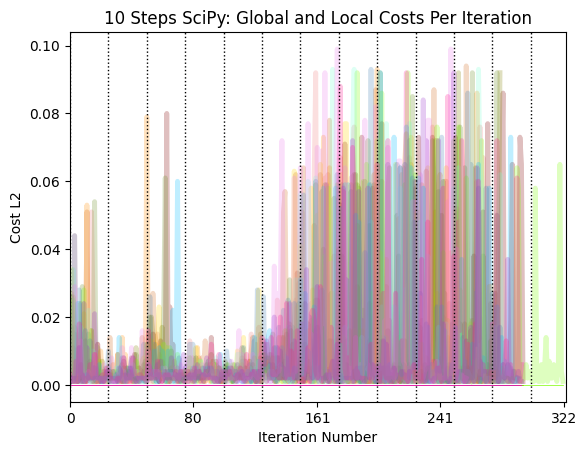

In [16]:
condensed_external_plotting(user_c0_10scipy_wclient_init, 'local', custom_title='10 Steps SciPy: Global and Local Costs Per Iteration')

## Using Final Global Model as Init for All

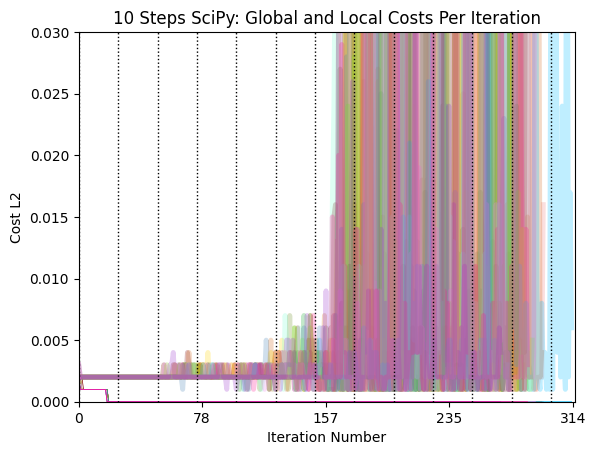

In [17]:
user_c0_10scipy_wglobal_init = [Client(i, global_model_10scipy.w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', num_steps=10, delay_scaling=0) for i in range(14)]
global_model_10scipy_wglobal_init = Server(2, D_0_7, 'FedAvg', user_c0_10scipy_wglobal_init)

for i in range(big_loop_iters):
    global_model_10scipy_wglobal_init.execute_FL_loop()
    
condensed_external_plotting(user_c0_10scipy_wglobal_init, 'local', ylim_max=0.03, custom_title='10 Steps SciPy: Global and Local Costs Per Iteration')

## Using Final Global Model as Init for All
> Global model also set to prev final global

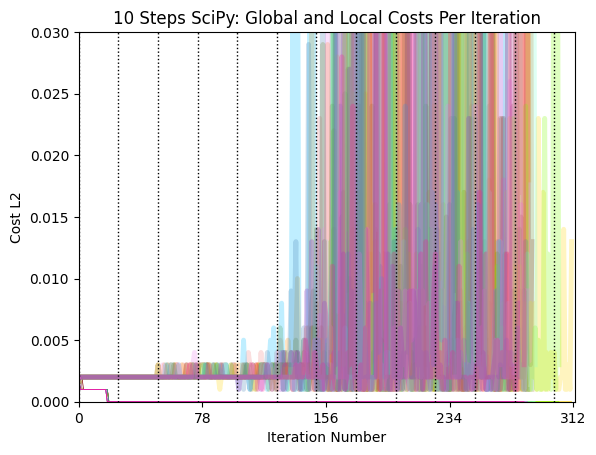

In [18]:
user_c0_10scipy_wglobalx2_init = [Client(i, global_model_10scipy.w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', num_steps=10, delay_scaling=0) for i in range(14)]
global_model_10scipy_wglobalx2_init = Server(2, global_model_10scipy.w, 'FedAvg', user_c0_10scipy_wglobalx2_init)

for i in range(big_loop_iters):
    global_model_10scipy_wglobalx2_init.execute_FL_loop()
    
condensed_external_plotting(user_c0_10scipy_wglobalx2_init, 'local', ylim_max=0.03, custom_title='10 Steps SciPy: Global and Local Costs Per Iteration')

## Full Scipy.Minimize
> Remember we are starting at update 10 already!!

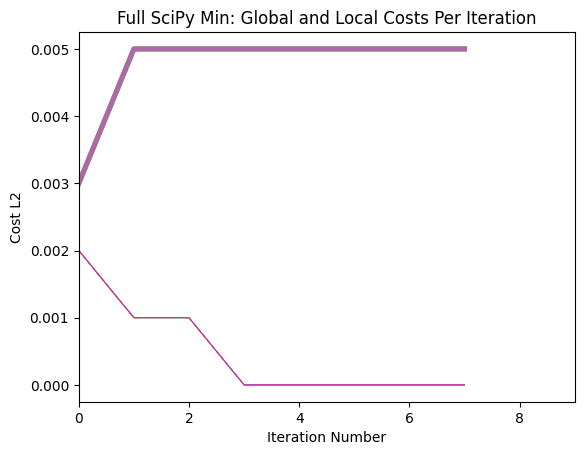

In [19]:
user_c0_fullscipy = [Client(i, D_0_7, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', delay_scaling=0) for i in range(14)]
global_model_fullscipy = Server(4, D_0_7, 'FedAvg', user_c0_fullscipy, C=1)

for i in range(8):
    global_model_fullscipy.execute_FL_loop()

condensed_external_plotting(user_c0_fullscipy, 'local', dim_reduc_factor=1, show_update_change=False, custom_title='Full SciPy Min: Global and Local Costs Per Iteration')

In [20]:
fullscipy_lim = 0.006

## Using Final Client Decs as Inits

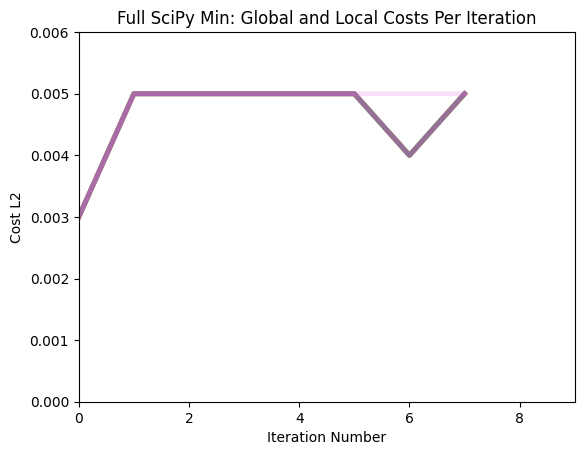

In [21]:
user_c0_fullscipy_wclient_init = [Client(i, user_c0_fullscipy[i].w, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', delay_scaling=0) for i in range(14)]
global_model_fullscipy_wclient_init = Server(4, D_0_7, 'FedAvg', user_c0_fullscipy_wclient_init, C=1)

for i in range(8):
    global_model_fullscipy_wclient_init.execute_FL_loop()

condensed_external_plotting(user_c0_fullscipy_wclient_init, 'local', ylim_max=fullscipy_lim, dim_reduc_factor=1, show_update_change=False, custom_title='Full SciPy Min: Global and Local Costs Per Iteration')

## Using Final Global Model as Init for All

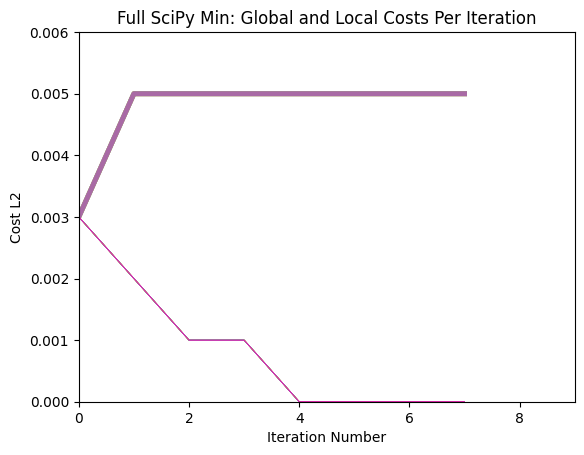

In [22]:
user_c0_fullscipy_wglobal_init = [Client(i, global_model_fullscipy.w, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', delay_scaling=0) for i in range(14)]
global_model_fullscipy_wglobal_init = Server(4, D_0_7, 'FedAvg', user_c0_fullscipy_wglobal_init, C=1)

for i in range(8):
    global_model_fullscipy_wglobal_init.execute_FL_loop()

condensed_external_plotting(user_c0_fullscipy_wglobal_init, 'local', ylim_max=fullscipy_lim, dim_reduc_factor=1, show_update_change=False, custom_title='Full SciPy Min: Global and Local Costs Per Iteration')

## Using Final Global Model as Init for All
> Global model also set to prev final global

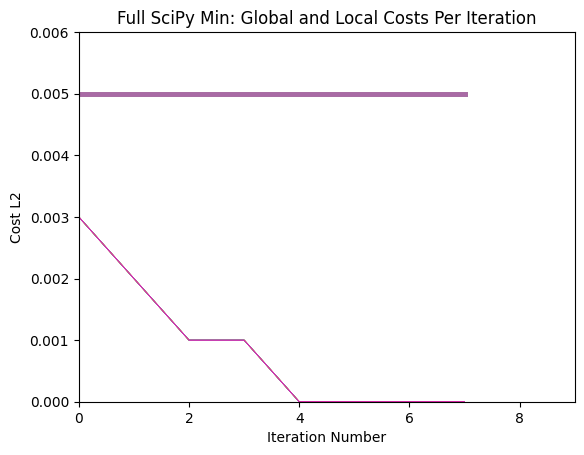

In [23]:
user_c0_fullscipy_wglobalx2_init = [Client(i, global_model_fullscipy.w, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', delay_scaling=0) for i in range(14)]
global_model_fullscipy_wglobalx2_init = Server(4, global_model_fullscipy.w, 'FedAvg', user_c0_fullscipy_wglobalx2_init, C=1)

for i in range(8):
    global_model_fullscipy_wglobalx2_init.execute_FL_loop()

condensed_external_plotting(user_c0_fullscipy_wglobalx2_init, 'local', ylim_max=fullscipy_lim, dim_reduc_factor=1, show_update_change=False, custom_title='Full SciPy Min: Global and Local Costs Per Iteration')